# Machine Learning with SAP Datasphere, Hands-On Workshop
## Explore and prepare the data in SAP Datasphere

Retrieve the credentials to connect to SAP Datasphere

In [1]:
import json
file = open('credentials.json', 'r')
credentials = json.load(file)
file.close()

Establish a connection with SAP Datasphere

In [2]:
import hana_ml.dataframe as dataframe
conn = dataframe.ConnectionContext(address  = credentials['hana_address'],
                                   port     = credentials['hana_port'], 
                                   user     = credentials['hana_user'], 
                                   password = credentials['hana_password'], 
                                  )
conn.connection.isconnected()

True

Point a hana_ml DataFrame to the table in SAP Datasphere, which holds the data that was loaded in the  previous Notebook. The variable df_remote is a reference to the data, which remains in SAP Datasphere. This command does not extract the data from SAP Datasphere. We will use such hana_ml Dataframes extensively in this Workshop as they allow to process the data in SAP Datasphere.

In [3]:
df_remote = conn.table('LUCERNEELECTRICITY')

Retrieve and display a few rows of data from SAP Datasphere. First restrict the hana_ml Dataframe to only 5 rows with the head()-method. Then download these 5 rows with the collect()-method into the Notebook.

In [4]:
df_remote.head(5).collect()

,TIMESTAMP,CONSUMPTION
0,2022-01-01 00:00:00,25112.140855
1,2022-01-01 00:15:00,24611.179355
2,2022-01-01 00:30:00,21784.375855
3,2022-01-01 00:45:00,20987.941355
4,2022-01-01 01:00:00,19466.977355


Get a first overview of the data

In [5]:
df_remote.describe().collect()

,column,count,unique,nulls,mean,std,min,max,median,25_percent_cont,25_percent_disc,50_percent_cont,50_percent_disc,75_percent_cont,75_percent_disc
0,CONSUMPTION,52404,52404,0,14644.234253,12553.75482,4994.015745,1.023296e+06,13412.452211,10614.073307,10614.027547,13412.452211,13412.386672,17361.186838,17361.09715
1,TIMESTAMP,52404,52404,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


All above statistics were calculated in SAP Datasphere. See the SELECT Statement that was created by the describe()-method and executed in SAP Datasphere.

In [6]:
print(df_remote.describe().select_statement)

SELECT * FROM (SELECT "SimpleStats".*, "Percentiles"."25_percent_cont", "Percentiles"."25_percent_disc", "Percentiles"."50_percent_cont", "Percentiles"."50_percent_disc", "Percentiles"."75_percent_cont", "Percentiles"."75_percent_disc" FROM (select 'CONSUMPTION' as "column", COUNT("CONSUMPTION") as "count", COUNT(DISTINCT "CONSUMPTION") as "unique", SUM(CASE WHEN "CONSUMPTION" is NULL THEN 1 ELSE 0 END) as "nulls", AVG(TO_DOUBLE("CONSUMPTION")) as "mean", STDDEV("CONSUMPTION") as "std", MIN("CONSUMPTION") as "min", MAX("CONSUMPTION") as "max", MEDIAN("CONSUMPTION") as "median" FROM (SELECT * FROM "LUCERNEELECTRICITY") AS "DT_0") AS "SimpleStats", (SELECT 'CONSUMPTION' as "column", * FROM (SELECT percentile_cont(0.25) WITHIN GROUP (ORDER BY "CONSUMPTION") AS "25_percent_cont", percentile_disc(0.25) WITHIN GROUP (ORDER BY "CONSUMPTION") AS "25_percent_disc", percentile_cont(0.50) WITHIN GROUP (ORDER BY "CONSUMPTION") AS "50_percent_cont", percentile_disc(0.50) WITHIN GROUP (ORDER BY "CON

Retrieve and plot the most recent 100 data points (each data point corresponds to a 15-minute interval)

In [7]:
df_data = df_remote.sort('TIMESTAMP').tail(n=100, ref_col='TIMESTAMP').collect()

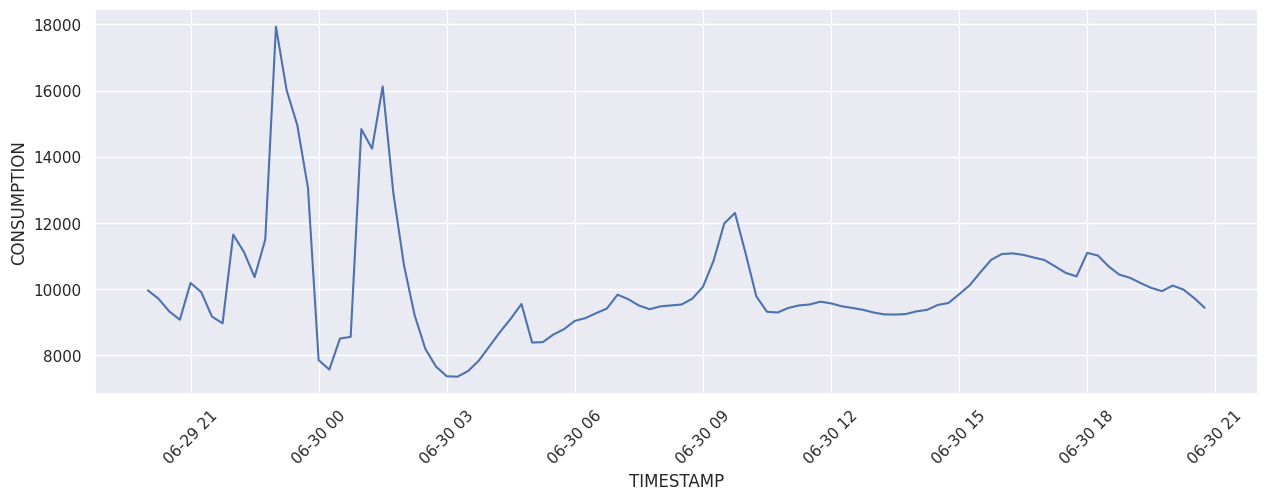

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
sns.set(rc={'figure.figsize':(15,5)})
sns.lineplot(data=df_data, x="TIMESTAMP", y="CONSUMPTION")
plt.xticks(rotation=45);

Add a column that standardises the TIMESTAMP column to the full hour, so  minutes 15, 30 and 45 are set to 0. This is done by subtracting the seconds that passed since the full hour. This column is part of the hana_ml Dataframe. The underlying table remains unchanged.

In [9]:
df_remote = df_remote.select('*', ("ADD_SECONDS(TIMESTAMP, -MINUTE(TIMESTAMP)*60)", 'DATEHOUR'))
df_remote.head(5).collect()

,TIMESTAMP,CONSUMPTION,DATEHOUR
0,2022-01-01 00:00:00,25112.140855,2022-01-01 00:00:00
1,2022-01-01 00:15:00,24611.179355,2022-01-01 00:00:00
2,2022-01-01 00:30:00,21784.375855,2022-01-01 00:00:00
3,2022-01-01 00:45:00,20987.941355,2022-01-01 00:00:00
4,2022-01-01 01:00:00,19466.977355,2022-01-01 01:00:00


Use the newly created column to aggregate the consumtion on the hour of the day, thereby adding the consumption from minutes 15, 30 and 45 to the corresponding full hour. This aggregation is done on the fly. The aggregate is not persisted as physical table.

In [10]:
df_rem_agg = df_remote.agg([('sum', 'CONSUMPTION', 'CONSUMPTION_H')], group_by='DATEHOUR').sort('DATEHOUR')
df_rem_agg.head(5).collect()

,DATEHOUR,CONSUMPTION_H
0,2022-01-01 00:00:00,92495.63742
1,2022-01-01 01:00:00,76818.07542
2,2022-01-01 02:00:00,74258.55192
3,2022-01-01 03:00:00,68339.55092
4,2022-01-01 04:00:00,63413.69092


Display the SELECT statement that is underpinning the hana_ml DataFrame df_rem_agg. Notice the sum("CONSUMPTION"), which creates the aggregation.

In [11]:
print(df_rem_agg.select_statement)

SELECT * FROM (SELECT "DATEHOUR", sum("CONSUMPTION") AS "CONSUMPTION_H" FROM (SELECT "TIMESTAMP", "CONSUMPTION", ADD_SECONDS(TIMESTAMP, -MINUTE(TIMESTAMP)*60) AS "DATEHOUR" FROM (SELECT * FROM "LUCERNEELECTRICITY") AS "DT_0") AS "DT_7" GROUP BY "DATEHOUR") AS "DT_9" ORDER BY "DATEHOUR" ASC


Add column that shows only the hour of the day. We use this column for further data analyis.

In [12]:
df_rem_agg = df_rem_agg.select('*', ('HOUR(DATEHOUR)', 'HOUR'))
df_rem_agg.head(5).collect()

,DATEHOUR,CONSUMPTION_H,HOUR
0,2022-01-01 00:00:00,92495.63742,0
1,2022-01-01 01:00:00,76818.07542,1
2,2022-01-01 02:00:00,74258.55192,2
3,2022-01-01 03:00:00,68339.55092,3
4,2022-01-01 04:00:00,63413.69092,4


See the distribution of consumption by the hour of the day. The creation of this chart might take a few seconds

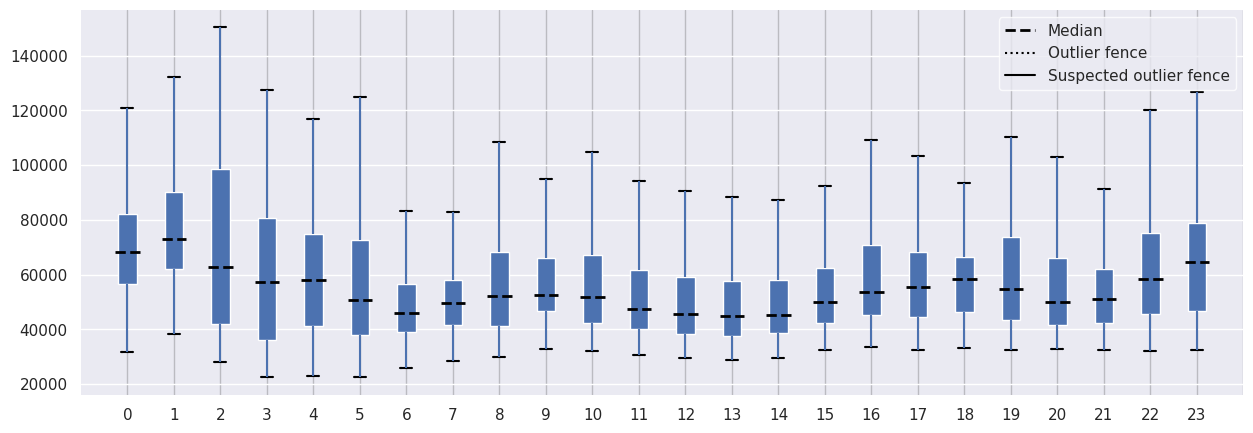

In [13]:
import matplotlib.pyplot as plt
from hana_ml.visualizers.eda import EDAVisualizer
f = plt.figure()
ax1 = f.add_subplot(111) # 111 refers to 1x1 grid, 1st subplot
eda = EDAVisualizer(ax1)
ax, cont = eda.box_plot(data=df_rem_agg, column='CONSUMPTION_H', groupby='HOUR', vert=True, outliers=False)

See the SELECT Statement that is behind the current hana_ml DataFrame

In [14]:
print(df_rem_agg.select_statement)

SELECT "DATEHOUR", "CONSUMPTION_H", HOUR(DATEHOUR) AS "HOUR" FROM (SELECT * FROM (SELECT "DATEHOUR", sum("CONSUMPTION") AS "CONSUMPTION_H" FROM (SELECT "TIMESTAMP", "CONSUMPTION", ADD_SECONDS(TIMESTAMP, -MINUTE(TIMESTAMP)*60) AS "DATEHOUR" FROM (SELECT * FROM "LUCERNEELECTRICITY") AS "DT_0") AS "DT_7" GROUP BY "DATEHOUR") AS "DT_9" ORDER BY "DATEHOUR" ASC) AS "DT_10"


Save the data structure, which includes the two calculated columns DATEHOUR and HOUR, as view for use in the next notebook. Only the semantics are saved, the data is not duplicated.

In [15]:
df_rem_agg.save('V_LUCERNEELECTRICITY', table_type='VIEW', force=True)